In [1]:
!pip3 install tensorflow==2.1.0
#!pip3 install pandas==0.25.3
#!pip3 install numpy==1.18.1

     |████████████████████████████████| 421.8MB 37kB/s 
     |████████████████████████████████| 450kB 31.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=549852129cc6b672a8acbf87740dfb4080894eaa3c8721637adb65fc1df9d533
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc1
    Uninstalling tensorflow-2.2.0rc1:
      Successfully uninstalled tensorflow-2.2.0rc1


In [0]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [0]:
import os
import numpy as np
import pandas as pd
import pickle
from tensorflow.keras import layers , activations , models , preprocessing, utils
import datetime

In [0]:
from google.colab import auth
auth.authenticate_user()

### Read Data In

In [0]:
def load_files(filenames):
    yield pd.read_csv(filenames)

In [0]:
# Specify path from Google Drive
data_file = '/content/drive/My Drive/deep_form/mini_training.csv'
committee_file = '/content/drive/My Drive/deep_form/slug_committee_labels.csv' 

# slugs and processed tokens
data_df = pd.concat(load_files(data_file))
data_df = data_df.drop(columns = 'token') # Remove unwanted column (token is redundant)
data_df['processed'] = data_df['processed'].astype(str) # Make sure we are dealing with strings

# committee info
committee_df = pd.read_csv(committee_file)
committee_df.drop(columns='Unnamed: 0', inplace=True) # Remove unwanted column
committee_df['committee'] = committee_df['committee'].str.lower() # Lower case committee names

# Time stamp to remember when we ran/trained this model run
timestamp = datetime.datetime.now().strftime("%d.%m.%H.%M")

In [0]:
# Merge both .csv (now DataFrames) into one
df = pd.merge(data_df, committee_df, on='slug')

# Group together based on slug and committee
df = df.groupby(['slug','committee'])['processed'].apply(
    lambda a: ' '.join([str(x) for x in a])).reset_index()

# Grab our input and target training data
input_texts = df['processed'].to_list()
target_texts = df['committee'].to_list()

# Set '<START> ' as the "start sequence" character
# for the targets, and ' <END>' as "end sequence" character.
target_texts = ['<START> ' + s + ' <END>' for s in target_texts]

### Format data for training

In [0]:
# Tokenization 
tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts( input_texts + target_texts )
VOCAB_SIZE = len( tokenizer.word_index )+1
print( 'VOCAB SIZE : {}'.format( VOCAB_SIZE ))

vocab = []
for word in tokenizer.word_index:
    vocab.append( word )

VOCAB SIZE : 25157


In [ ]:
# The tokenizer will transform the text into vectors, it’s important to have the same vector space
# between training & predicting. The most common way is to save tokenizer and load the same
# tokenizer at predicting time using pickle.

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
# encoder_input_data
tokenized_inputs = tokenizer.texts_to_sequences( input_texts )
maxlen_inputs = max( [ len(x) for x in tokenized_inputs ] )
padded_inputs = preprocessing.sequence.pad_sequences(tokenized_inputs,
                                                    maxlen=maxlen_inputs,
                                                    padding='post' )
encoder_input_data = np.array( padded_inputs )
print("Encoder input shape: {}".format(encoder_input_data.shape , maxlen_inputs ))

# decoder_input_data
tokenized_targets = tokenizer.texts_to_sequences( target_texts )
maxlen_targets = max( [ len(x) for x in tokenized_targets ] )
padded_targets = preprocessing.sequence.pad_sequences(tokenized_targets,
                                                      maxlen=maxlen_targets, padding='post' )
decoder_input_data = np.array( padded_targets )
print("Decoder input shape: {}".format(decoder_input_data.shape , maxlen_targets ))

# decoder_output_data
tokenized_answers = tokenizer.texts_to_sequences( target_texts )
for i in range(len(tokenized_answers)) :
    tokenized_answers[i] = tokenized_answers[i][1:]
padded_targets = preprocessing.sequence.pad_sequences( tokenized_answers,
                                                      maxlen=maxlen_targets , padding='post' )
onehot_answers = utils.to_categorical( padded_targets , VOCAB_SIZE )
decoder_output_data = np.array( onehot_answers )
print("Decoder output data shape: {}".format(decoder_output_data.shape ))

Encoder input shape: (4510, 13678)
Decoder input shape: (4510, 12)
Decoder output data shape: (4510, 12, 25157)


## seq2seq model¶


In [0]:
# Hyperparameters
batch_size = 50
num_epochs = 75
num_units  = 200
loss_function = 'categorical_crossentropy'
validation_split = 0.2

# Files to save:
model_filename = 'model.' + timestamp + '.h5'
learning_curve_image_name = 'lstm.'+ timestamp + '.png'

In [0]:
encoder_inputs = tf.keras.layers.Input(shape=( None , ))
encoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 200 , mask_zero=True ) (encoder_inputs)
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM( 200 , return_state=True )( encoder_embedding )
encoder_states = [ state_h , state_c ]

decoder_inputs = tf.keras.layers.Input(shape=( None ,  ))
decoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 200 , mask_zero=True) (decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM( 200 , return_state=True , return_sequences=True )
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = tf.keras.layers.Dense( VOCAB_SIZE , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss=loss_function, metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    5031400     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    5031400     input_2[0][0]                    
______________________________________________________________________________________________

In [0]:
# Train model
model.fit([encoder_input_data , decoder_input_data], decoder_output_data,
          batch_size=batch_size, epochs=num_epochs,
          validation_split=validation_split ) 

# Save model
model.save( os.path.join(save_path, model_filename) ) 

Train on 3608 samples, validate on 902 samples
Epoch 1/75
3608/3608 [==============================] - 55s 15ms/sample - loss: 1.9597 - acc: 0.2939 - val_loss: 1.7123 - val_acc: 0.2774
Epoch 2/75
3608/3608 [==============================] - 42s 12ms/sample - loss: 1.3765 - acc: 0.4329 - val_loss: 1.4117 - val_acc: 0.4812
Epoch 3/75
3608/3608 [==============================] - 42s 12ms/sample - loss: 1.1548 - acc: 0.5035 - val_loss: 1.2714 - val_acc: 0.5336
Epoch 4/75
3608/3608 [==============================] - 43s 12ms/sample - loss: 1.0240 - acc: 0.5568 - val_loss: 1.1846 - val_acc: 0.5613
Epoch 5/75
3608/3608 [==============================] - 42s 12ms/sample - loss: 0.9230 - acc: 0.6004 - val_loss: 1.1224 - val_acc: 0.5684
Epoch 6/75
3608/3608 [==============================] - 43s 12ms/sample - loss: 0.8435 - acc: 0.6424 - val_loss: 1.0464 - val_acc: 0.6126
Epoch 7/75
3608/3608 [==============================] - 43s 12ms/sample - loss: 0.7753 - acc: 0.6735 - val_loss: 0.9938 - val

### Loss plots

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

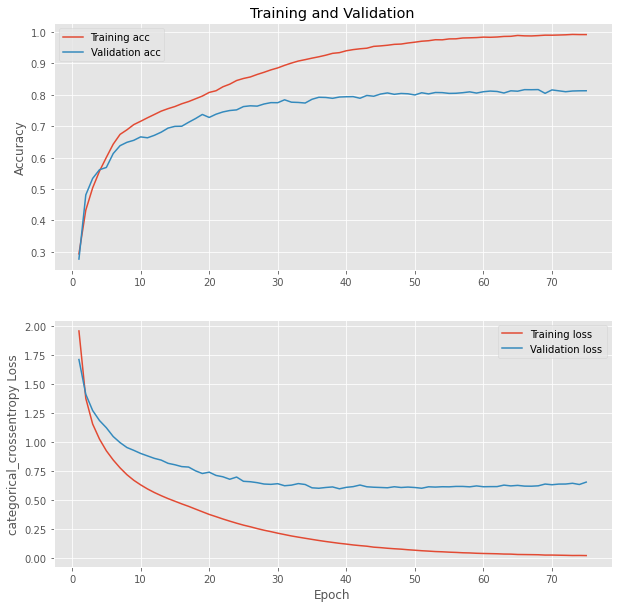

In [0]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Loss and Accuracy Plots
nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(10,10))
axes[0].plot(epochs, acc, label='Training acc')
axes[0].plot(epochs, val_acc, label='Validation acc')
axes[0].set_title('Training and Validation')
axes[0].set_ylabel('Accuracy')

axes[1].plot(epochs, loss, label='Training loss')
axes[1].plot(epochs, val_loss, label='Validation loss')
axes[1].set_ylabel('{} Loss'.format(loss_function))
axes[1].set_xlabel('Epoch')

for i in range(nrows):
    axes[i].legend()

# Save image
IMAGES_PATH = os.path.join(save_path, learning_curve_image_name)
plt.savefig(IMAGES_PATH, bbox_inches = 'tight')

In [0]:
# save model information
save_path = './drive/My Drive/deep_form/'
file_name = 'vocab_info.txt'
flen = open(os.path.join(save_path, file_name),'w+')
flen.write('Model time stamp: {}\n'.format(timestamp))
flen.write('Number of samples: {}\n'.format(len(input_texts)))
flen.write('VOCAB SIZE : {}\n'.format( VOCAB_SIZE ))
flen.write('Max input sequence length: {}\n'.format(maxlen_inputs))
flen.write('Max target sequence length: {}\n'.format(maxlen_targets))
flen.write("Encoder input shape: {}\n".format(encoder_input_data.shape , maxlen_inputs ))
flen.write("Decoder input shape: {}\n".format(decoder_input_data.shape , maxlen_targets ))
flen.write("Decoder output data shape: {}\n".format(decoder_output_data.shape ))
flen.write("Batch size: {}\n".format(batch_size))
flen.write("Number of epochs: {}\n".format(num_epochs))
flen.write("Number of units in encoder and decoder: {}\n".format(num_units))
flen.write("Loss function: {}\n".format(loss_function))
flen.write("Validation split: {}\n".format(validation_split))
flen.close()

## Inference Section

In [0]:
def make_inference_models():
    """
    Create inference models which help in predicting answers.
    Encoder inference model : Takes the question as input and outputs LSTM states ( h and c ).
    Decoder inference model : Takes in 2 inputs, one are the LSTM states ( Output of encoder model ),
    second are the answer input seqeunces ( ones not having the <start> tag ). It will output the
    answers for the question which we fed to the encoder model and its state values.
    """
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 200 ,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 200 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model

def str_to_tokens( sentence : str ):
    """
    Define a method str_to_tokens which converts str input to Integer tokens with padding.
    """
    words = sentence.lower().split()
    tokens_list = list()
    for word in words:
        tokens_list.append( tokenizer.word_index[ word ] ) 
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=maxlen_inputs , padding='post')


---
---
## Insert sequence input to get a committee name
This is cheating, but let's try to give it a token from our training set and see if it is mapping to what it has already seen. In this case, it should spit out the corrct committee name.

What happens when we give it a slug's tokens it has already seen?  
Attempt_1 :

In [0]:
instance = 7
# Grab only first 500 strings, be careful to check it is in vocab.
input_test = input_texts[instance][:500] 

print("Expected output from below: ")
print(target_texts[instance])

Expected output from below: 
<START> democratic congressional campaign committee <END>


In [0]:
enc_model , dec_model = make_inference_models()

states_values = enc_model.predict( str_to_tokens( input( 'Enter tokens from a slug : ' ) ) )
empty_target_seq = np.zeros( ( 1 , 1 ) )
empty_target_seq[0, 0] = tokenizer.word_index['start']
stop_condition = False
decoded_translation = ''
while not stop_condition :
    dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
    sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
    sampled_word = None
    for word , index in tokenizer.word_index.items() :
        if sampled_word_index == index :
            decoded_translation += ' {}'.format( word )
            sampled_word = word
    
    if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_targets:
        stop_condition = True
        
    empty_target_seq = np.zeros( ( 1 , 1 ) )  
    empty_target_seq[ 0 , 0 ] = sampled_word_index
    states_values = [ h , c ] 

print( decoded_translation )

Enter tokens from a slug : print date page 1 3 order order order rev 707565 alt order 06283268 product desc issdccc estim 1473 kare flight date primari ae jim quinn origin date rev sale offic tphi order type polit sale region nat agenc name great american media pol buy contact bill type cash bill contact bill calendar broadcast 1010 wisconsin ave nw ste 800 bill cycl eomeoc washington dc 20007 agenc commiss advertis name democrat congression campaign committe demograph a35 new busi thru product code iscandidateu hous
 democratic congressional campaign committee end


Attempt 2:

In [0]:
instance = 42
input_test = input_texts[instance][:500] # Grab only first 500 strings, be careful to check it is in vocab.

In [0]:
enc_model , dec_model = make_inference_models()

states_values = enc_model.predict( str_to_tokens( input( 'Enter tokens from a slug : ' ) ) )
empty_target_seq = np.zeros( ( 1 , 1 ) )
empty_target_seq[0, 0] = tokenizer.word_index['start']
stop_condition = False
decoded_translation = ''
while not stop_condition :
    dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
    sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
    sampled_word = None
    for word , index in tokenizer.word_index.items() :
        if sampled_word_index == index :
            decoded_translation += ' {}'.format( word )
            sampled_word = word
    
    if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_targets:
        stop_condition = True
        
    empty_target_seq = np.zeros( ( 1 , 1 ) )  
    empty_target_seq[ 0 , 0 ] = sampled_word_index
    states_values = [ h , c ] 

print( decoded_translation )



Enter tokens from a slug : contract agreement print date page 1 2 contract wvit contract revis alt order 1422 new britain ave 329181 west hartford ct 06110 product primari tv contract date estim 2597 advertis origin date revis lisa wilsonfoley congress bill cycl bill calendar cashtrad eomeoc broadcast cash strateg media placement station account execut sale offic 7669 stager loop delawar oh 43015 wvit janet schmidt detroit nso special handl demograph rhh total rate idb advertis code product code agenc ref advertis r
 d tarkanian for cong end


In [0]:
print("This is what it should spit out:\n{}".format(target_texts[instance]))

print("\nWhat we have returned:\n{}".format(decoded_translation))

This is what it should spit out:
<START> lisa wilson-foley for congress <END>

What we have returned:
 d tarkanian for cong end


---
---
### To Do [as of 25/03/20]:
* Use this on a test set.  

* Fix decoder so it automatically removes tokens it has never seen before.  

* Rewrite decoder as a functin.